First import all the things and setup the plot things

In [1]:
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import time
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib
from importlib import reload
import speclite.filters
from scipy.interpolate import interp1d, RegularGridInterpolator as rgi
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import median_filter
from scipy.signal import medfilt, correlate
from numpy.random import poisson, randn
import copy 

SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 48

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/usr/local/lib/python3.6/dist-packages/pysynphot/locations.py:47: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/lib/python3.6/dist-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Path and Telescope Setup

In [2]:
#Setup the path to the peripheral files
path = '/scr3/dmawet/ETC/'
#Load the filter objects from speclite
filters = spectrum.load_filters()

In [3]:
#-- Telescope Setup
# Contains telescope params, site characteristics, and current conditions
keck = telescope.Keck(path=path)
keck.airmass=1.1
keck.water_vapor=1.6
keck.seeing = keck.median_seeing

## Basic Observation parameters to play with

In [4]:
#-- Instrument parameters
exp_time = 600           # [s]
main_filter = 'TwoMASS-K'   # Band for observation
n_exposures = 12
vort_charge = 1             # Vortex charge for VFN

#-- Host properties
#First set the host properties for a Phoenix model. 
host_properties = {"StarLogg":4.00*u.dex(u.cm/u.s**2),"StarTeff":4400*u.K,"StarZ":'-0.0',"StarAlpha":"0.0",
                    "StarRadialVelocity":-50*u.km/u.s,
                    "StarVsini":10*u.km/u.s,
                    "StarLimbDarkening":0.2}
host_filter = 'TwoMASS-K'
host_mag = 5.0
host_dist = 30.0 * u.pc
host_diam = 1 *u.mas #angular diameter of the star

#-- Planet properties
obj_filter = 'TwoMASS-K'
obj_mag = 18    # (for test simulation only)
obj_rad_vel = 10 * u.km/u.s
obj_rad_spin = 8*u.km/u.s
obj_limb_dark = 0.2
# (non-variable values in next line are for test simulation only)
obj_properties = {"StarLogg":3.25*u.dex(u.cm/u.s**2),"StarTeff":700*u.K,"StarRadialVelocity":obj_rad_vel,"StarVsini":obj_rad_spin,
                  "StarLimbDarkening":obj_limb_dark}

# Angular separation of the companion, in milliarcsecond (for test simulation only)
host_properties['AngSep'] = 45*0.9 *u.mas  # 0.9lam/D is the peak planet location for charge 1 and 45mas is 1lam/D at 2um (k-band)

#-- Calibration properties
cal = 0.001 #Telluric calibration accuracy of 0.1%

## Instrument Setup
The instrument object contains static instrument params and current observing setup

In [5]:
#Initialize a kpic object and set the current filter
kpic = instrument.kpic_phaseII(telescope=keck)
kpic.set_current_filter(main_filter)

#Get the set of wavelengths based on the current instrument setup
wavelengths = kpic.get_wavelength_range()

# Set the observing mode: Exposure time (per exposure), Number of Exposures,filter name, wavelength array
kpic.set_observing_mode(exp_time,n_exposures,main_filter, wavelengths,mode="vfn",vortex_charge=vort_charge) 

## Host spectrum setup

In [6]:
#Now setup the user parameters that a Phoenix model needs: (path, object_filter, magnitude_in_object_filter,
# filters_object,current_filter). 
host_user_params = (path,host_filter,host_mag,filters,kpic.current_filter)

#Generate the spectrum! (Here we apply a doppler shift and rotationally broaden)
host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,kpic.current_R,model="Phoenix",
                                              user_params=host_user_params,doppler_shift=True,broaden=True,
                                              delta_wv=kpic.current_dwvs)

/usr/local/lib/python3.6/dist-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


Plot the host spectrum

Text(0, 0.5, 'Spectrum [ph / (Angstrom cm2 s)]')

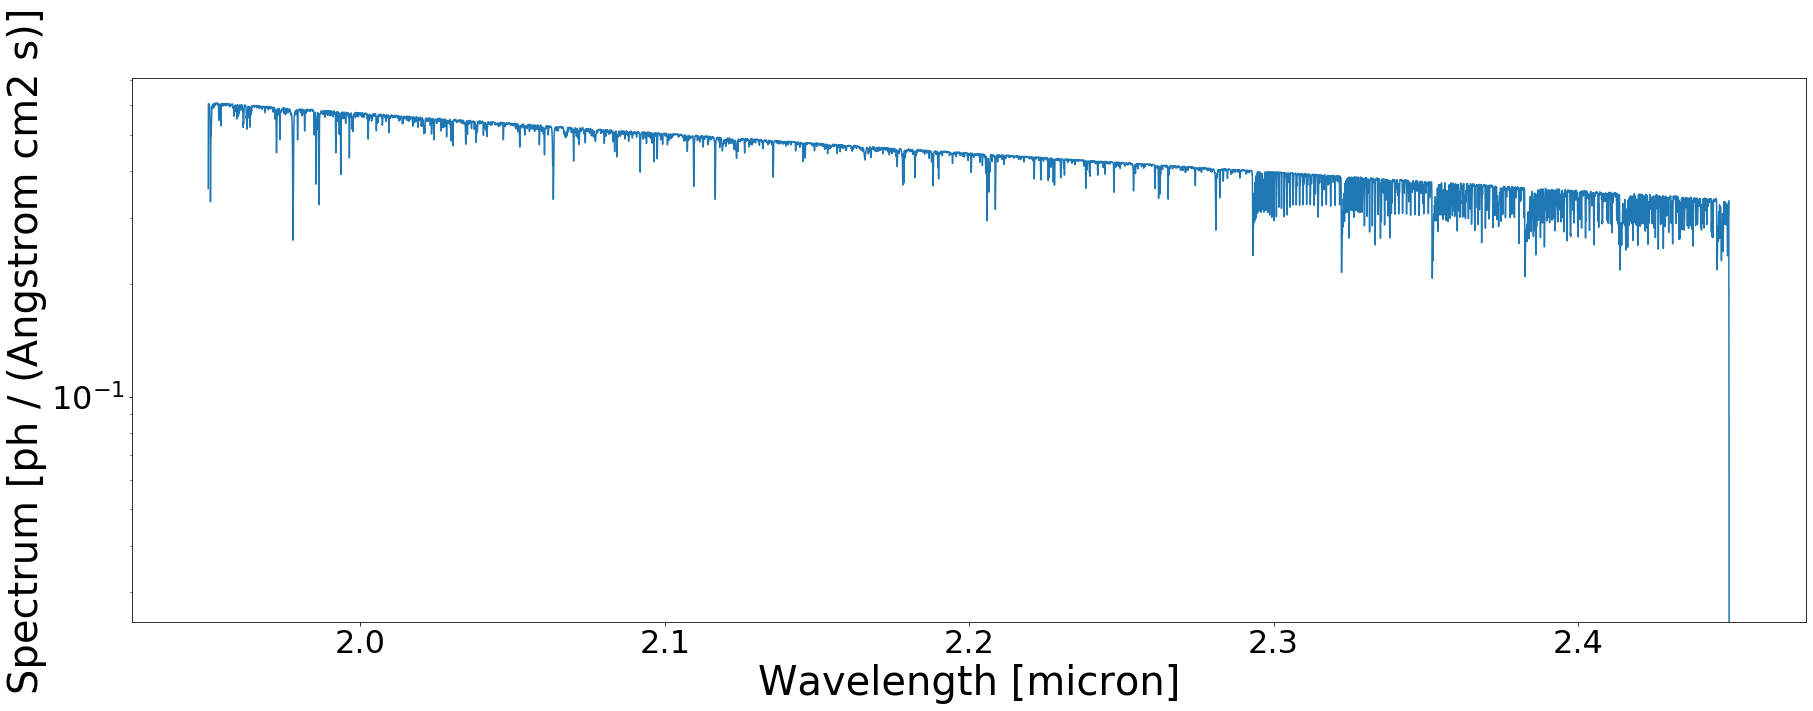

In [7]:
plt.figure(figsize=(30,10))

plt.semilogy(host_spectrum.wvs,host_spectrum.spectrum)

plt.xlabel("Wavelength [{}]".format(host_spectrum.wvs.unit))
plt.ylabel("Spectrum [{}]".format(host_spectrum.spectrum.unit))

## Planet spectrum setup

In [8]:
obj_user_params = (path,obj_filter,obj_mag,filters,kpic.current_filter)

obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,kpic.current_R,model="Sonora",
                                             user_params=obj_user_params,doppler_shift=True,broaden=True,
                                             delta_wv=kpic.current_dwvs)

# Convert to contrast units
obj_spectrum.spectrum /= host_spectrum.spectrum

/home/aidan/.local/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Plot the planet spectrum

(1e-10, 0.0001)

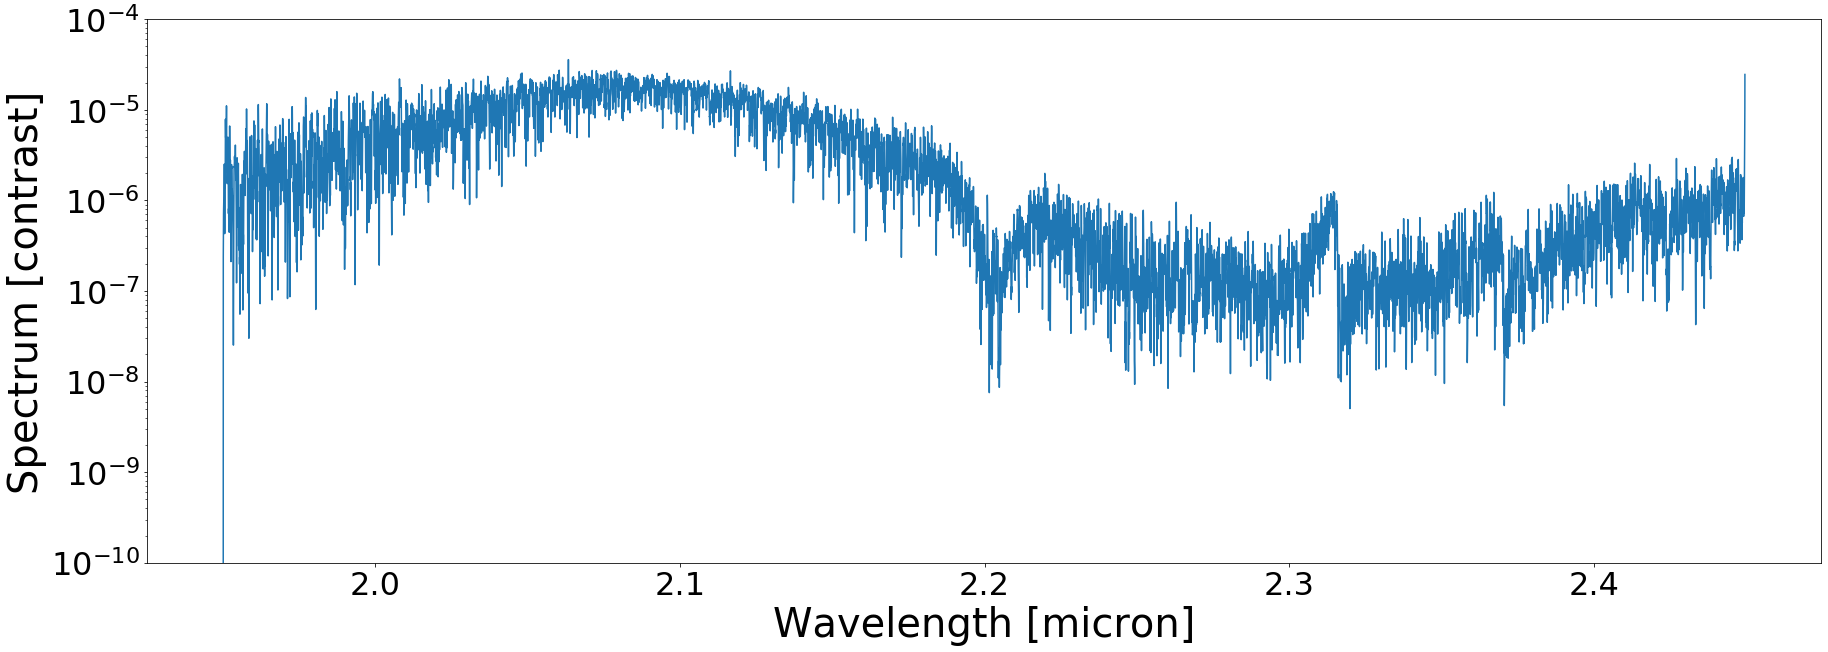

In [9]:
plt.figure(figsize=(30,10))

plt.semilogy(obj_spectrum.wvs,obj_spectrum.spectrum)

plt.xlabel("Wavelength [{}]".format(obj_spectrum.wvs.unit))
plt.ylabel("Spectrum [contrast]")
plt.ylim(1e-10,1e-4)

# Simulate a single test observation

In [10]:
# Convert angular sep to arcseconds use later in the script
planet_sep = host_properties['AngSep'].to(u.arcsec)

# Set host diameter in instrument object (defines nulling geometric leakage)
kpic.set_vfn_host_diameter(host_diam)

#Get the host star magnitude in the AO filter
host_properties["StarAOmag"] = spectrum.get_model_ABmags(host_properties,[kpic.ao_filter], model='Phoenix',
                                                         verbose=False,user_params = host_user_params)
kpic.ao_mag = host_properties["StarAOmag"]

#KPIC doesn't care about the spectral type, but we need to include the paramter
host_properties['StarSpT'] = None

In [11]:
#-- Simulate a regular observation
obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation(keck,kpic,host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                       post_processing_gain = np.inf,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False, 
                                                                                      plot=False,
                                                                                      sky_on=True)

#-- Simulate observation without sky effects
obj_spec_no_sky,_,_,_ = observation.simulate_observation(keck,kpic,
                                                                                      host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = np.inf,
                                                                                      return_noise_components=False,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False,
                                                                                      plot=False,
                                                                                      sky_on=False)

#-- Get speckle noise
speckle_noise = kpic.get_speckle_noise(planet_sep,host_properties['StarAOmag'],kpic.current_filter,wavelengths,host_properties['StarSpT'],keck)[0]

#-- Compute Systematics
#The photon flux at the object will be the stellar flux multipled by the contrast there:
host_flux_at_obj = stellar_spec*speckle_noise

systematics = (cal*(host_flux_at_obj+thermal_spec))**2 #Variance of systematics

noise_plus_systematics = np.sqrt(total_noise**2+systematics)

#-- Calculate CCF SNR
#Compute sky transmission lines convolved with line spread function
#Get the wavelength spacing
dwvs = np.abs(wavelengths - np.roll(wavelengths, 1))
dwvs[0] = dwvs[1]
dwv_mean = np.mean(dwvs)
lsf_fwhm = (kpic.lsf_width/dwv_mean).decompose() #Get the lsf_fwhm in units of current wavelength spacing
lsf_sigma = lsf_fwhm/(2*np.sqrt(2*np.log(2))) #Convert to sigma
#Get sky transmission lsf
sky_transmission_lsf = gaussian_filter(keck.get_atmospheric_transmission(wavelengths),lsf_sigma.value)

#Get CCF SNR
ccf_snr = signal.compute_ccf_snr_matchedfilter(obj_spec, obj_spec_no_sky, noise_plus_systematics, 
                                            sky_transmission_lsf,
                                               systematics_residuals = cal, 
                                               norm_cutoff=0.8)

/home/aidan/.local/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## Plot the simulation results

Text(0.5, 1.0, 'Object Spectrum only')

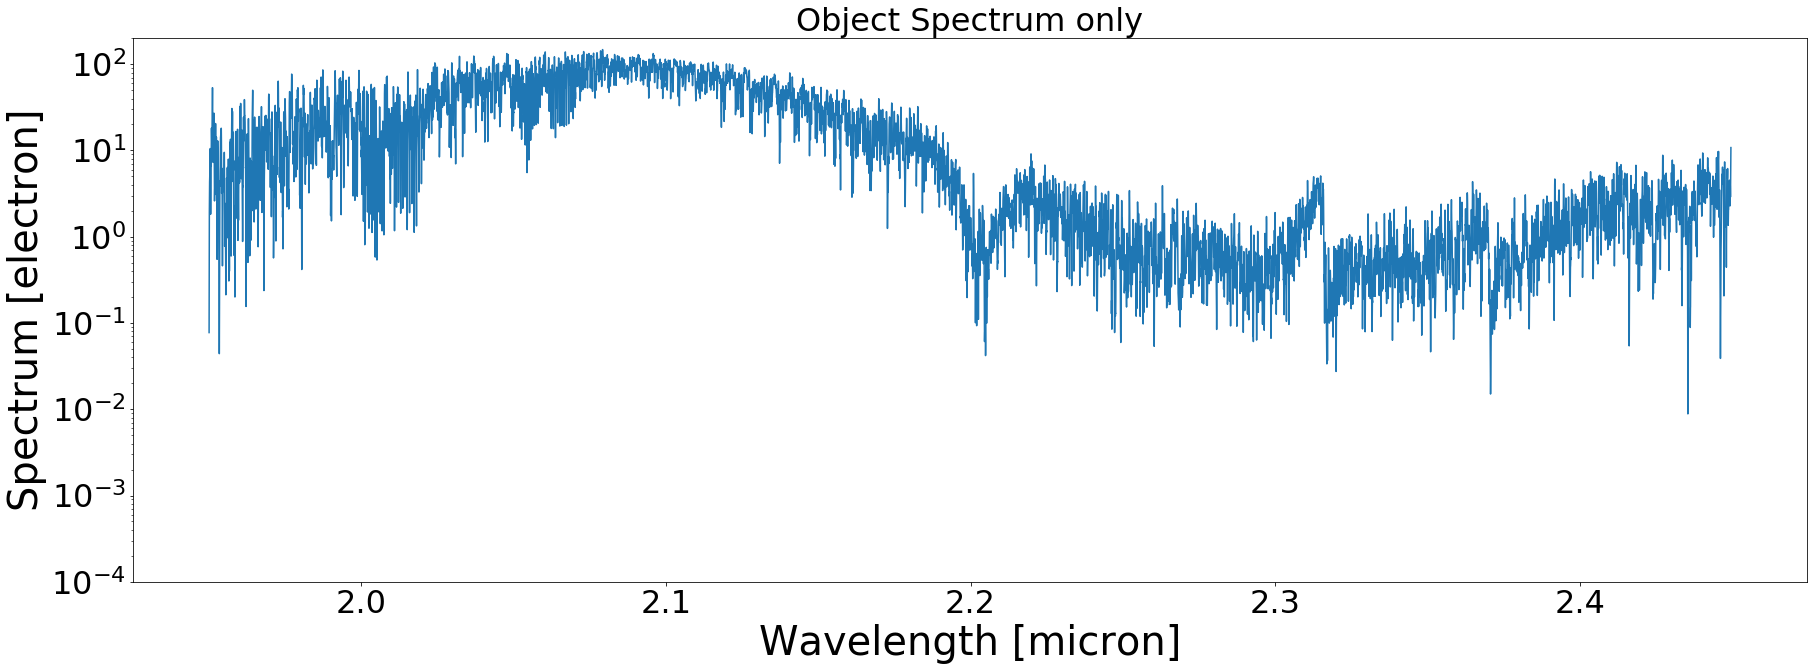

In [12]:
#-- Plot just the planet spectrum
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spec)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
plt.ylim(1e-4,2e2)
plt.title("Object Spectrum only")

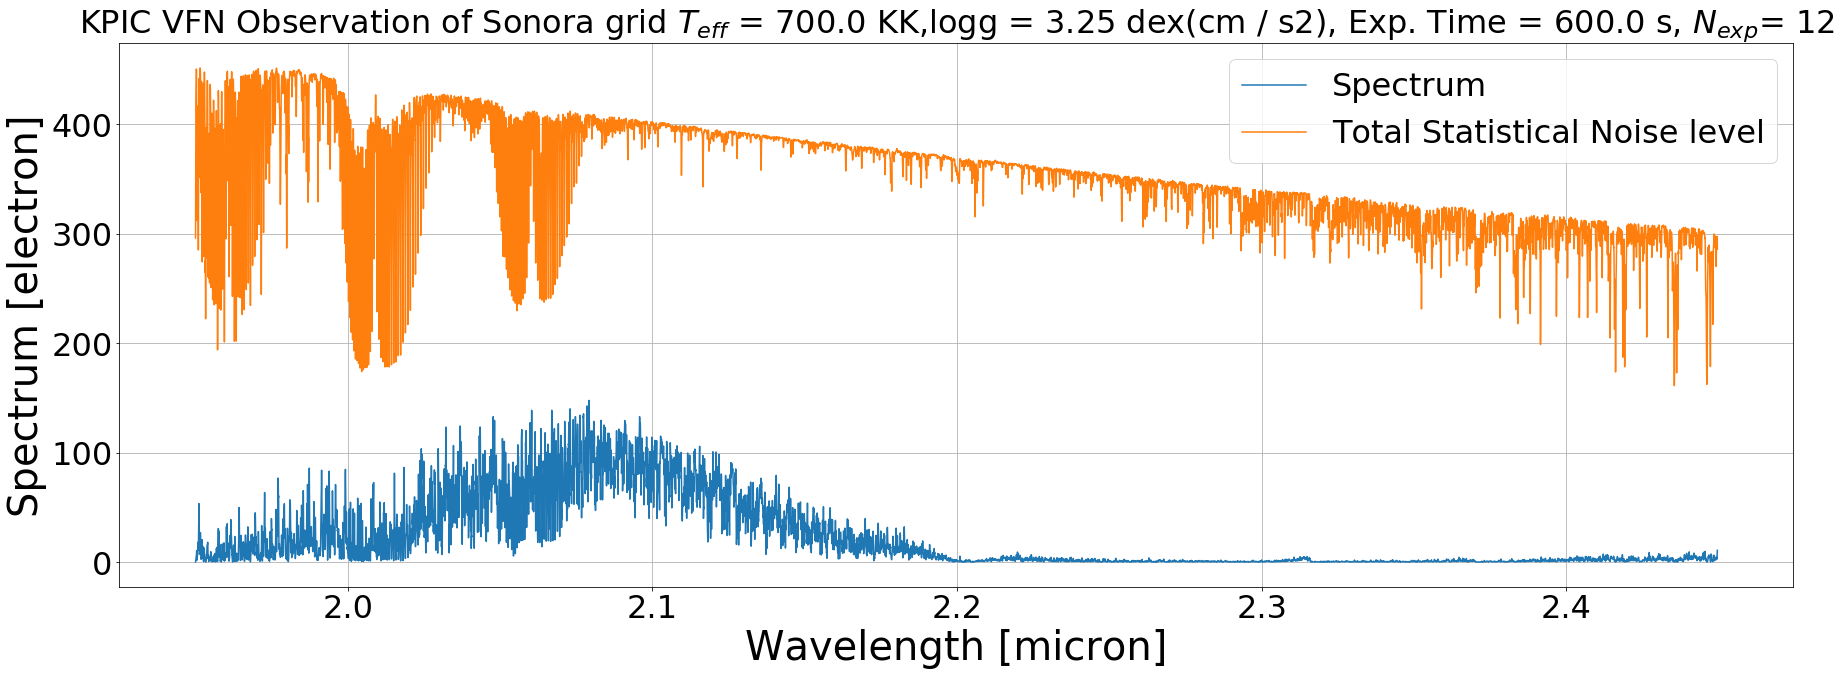

In [13]:
#-- Show planet spectrum and system noise simultaneously
plt.figure(figsize=(30,10))

plt.plot(wavelengths,obj_spec, label="Spectrum")
plt.plot(wavelengths,total_noise, label="Total Statistical Noise level")
plt.legend()

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
plt.title(r"KPIC VFN Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"],obj_properties["StarLogg"],kpic.exposure_time,kpic.n_exposures))
plt.grid()

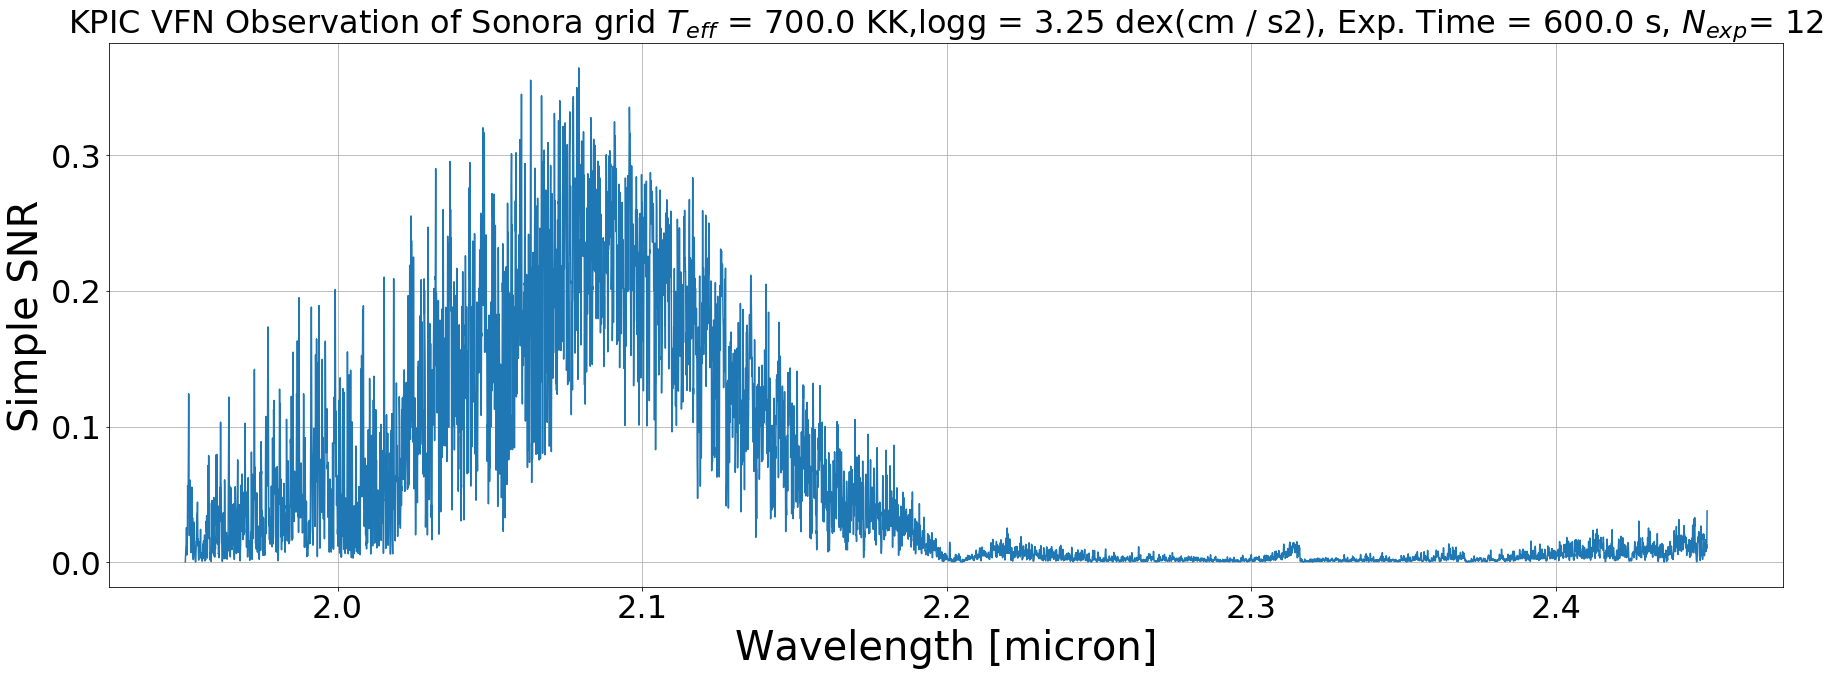

In [14]:
#-- Calculate simple SNR
plt.figure(figsize=(30,10))

plt.plot(wavelengths,obj_spec/total_noise)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Simple SNR")
plt.title(r"KPIC VFN Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"],obj_properties["StarLogg"],kpic.exposure_time,kpic.n_exposures))
plt.grid()
#plt.xlim(0.9,2.4)
#plt.ylim(-0.1,2.)

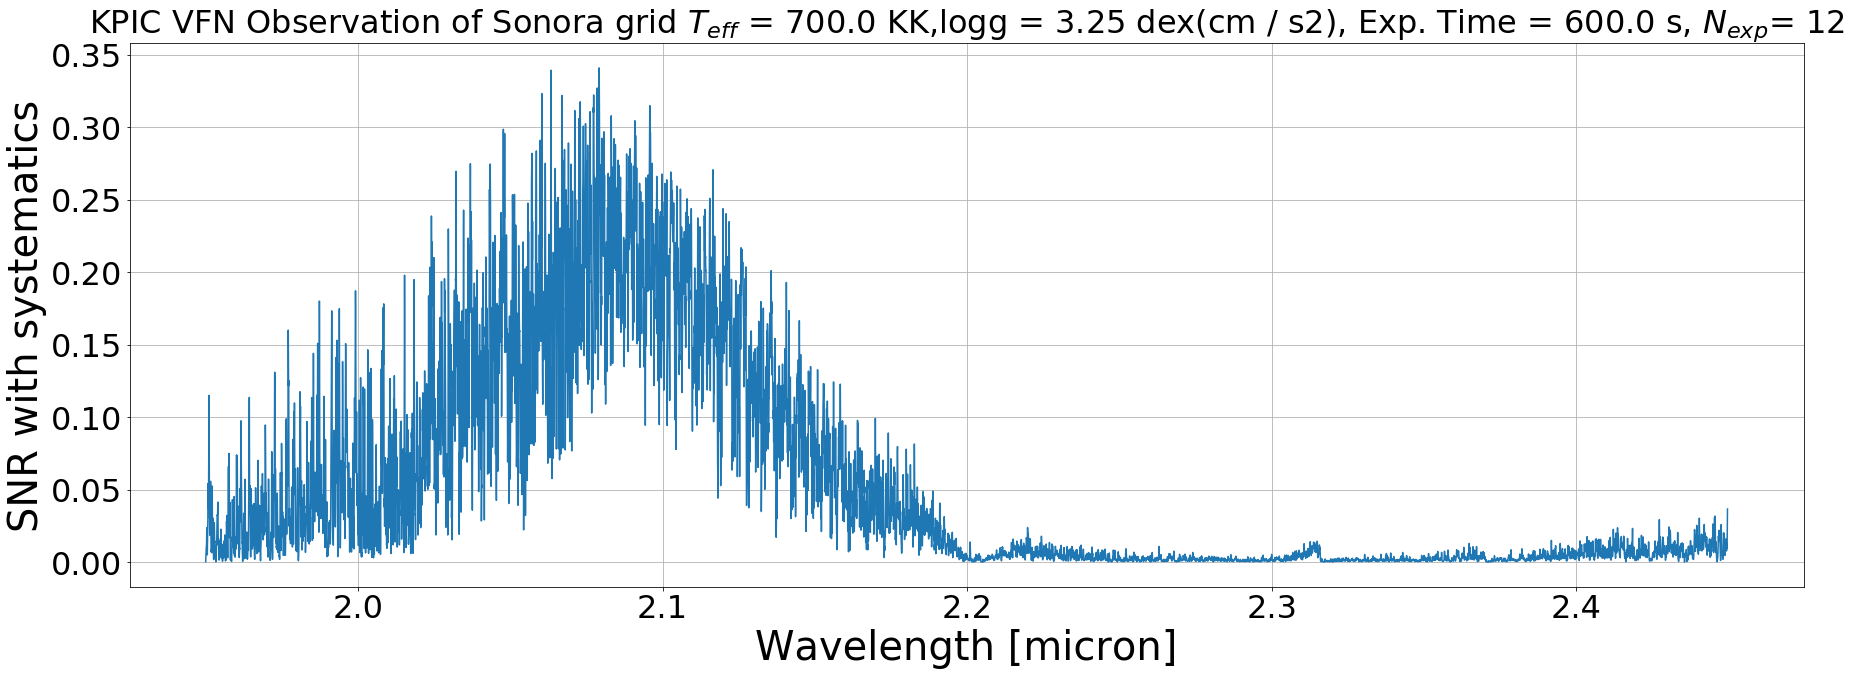

In [15]:
#-- Calculate SNR with Systematics
plt.figure(figsize=(30,10))

plt.plot(wavelengths,obj_spec/noise_plus_systematics)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("SNR with systematics")
plt.title(r"KPIC VFN Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"],obj_properties["StarLogg"],kpic.exposure_time,kpic.n_exposures))
# plt.ylim(-0.01,0.4)
#plt.xlim(0.9,2.4)
plt.grid()

Text(0, 0.5, 'Spectrum [electron2]')

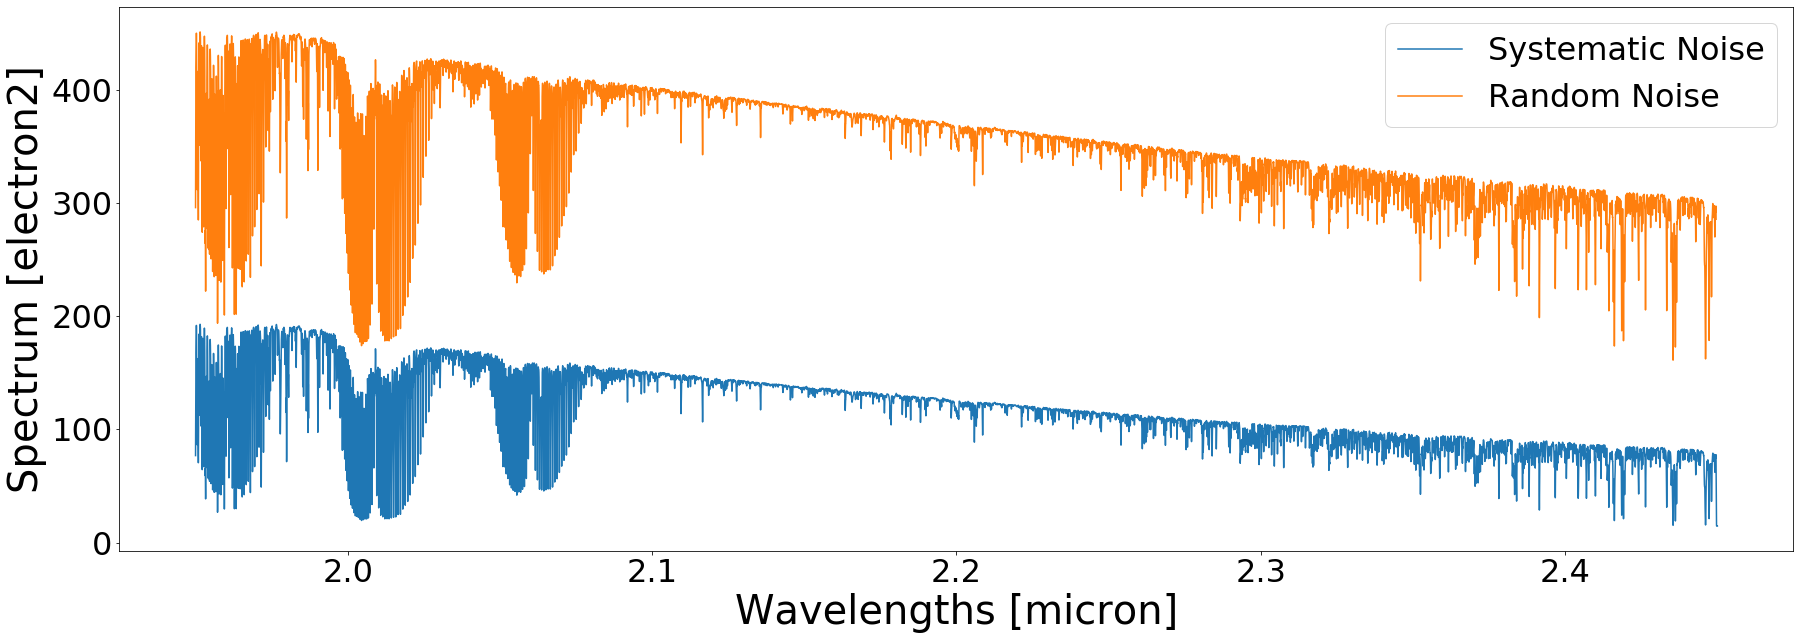

In [16]:
#-- Show Systematics vs. random noise
plt.figure(figsize=(30,10))

plt.plot(wavelengths,np.sqrt(systematics),label="Systematic Noise")
plt.plot(wavelengths,total_noise,label="Random Noise")
plt.legend()

plt.xlabel("Wavelengths [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(systematics.unit))

In [17]:
#-- Show CCF SNR
print(ccf_snr)

4.018874789197354 1 / electron


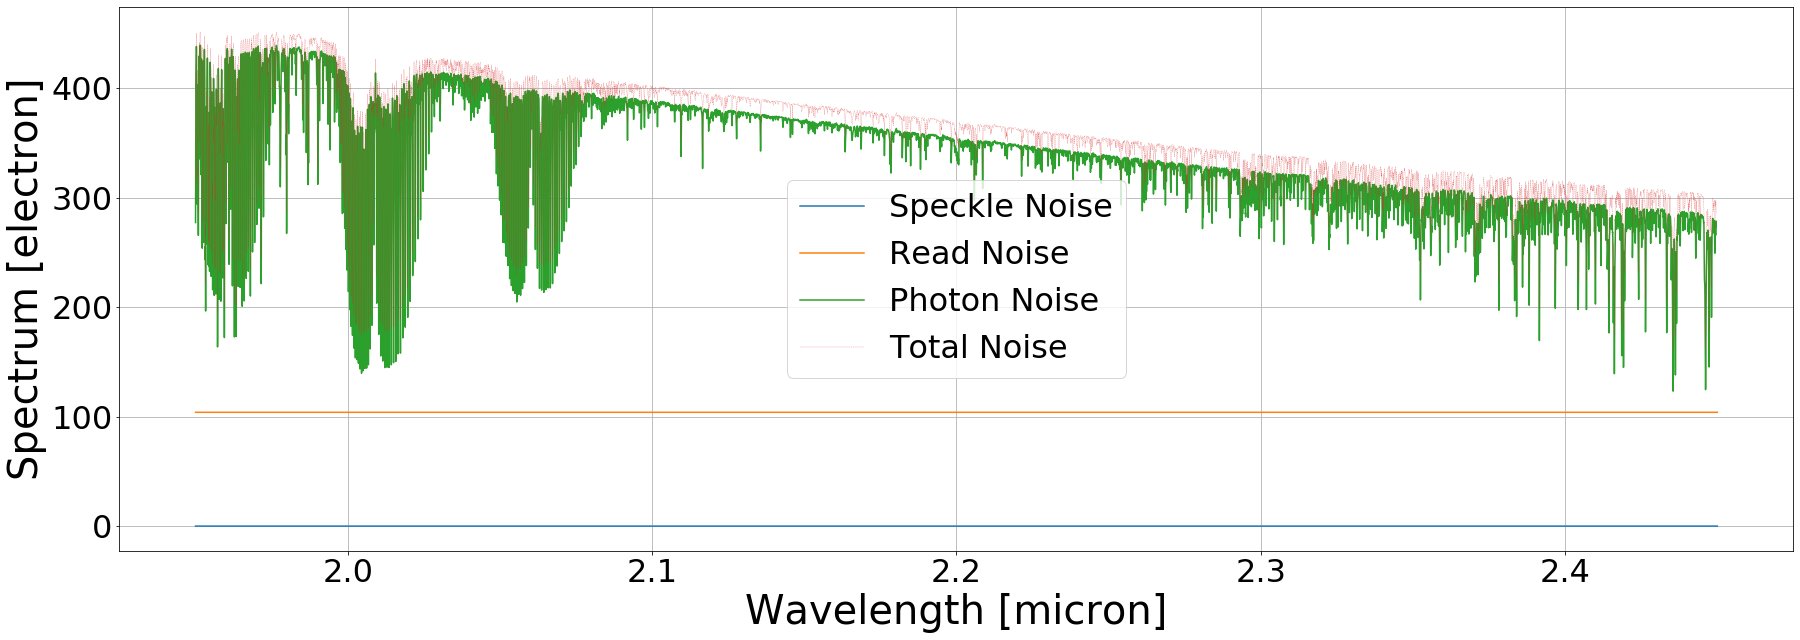

In [18]:
#-- Show relative contribution of each noise component
plt.figure(figsize=(30,10))

plt.plot(wavelengths,noise_components[0],label="Speckle Noise")
plt.plot(wavelengths,noise_components[1],label="Read Noise")
plt.plot(wavelengths,noise_components[2],label="Photon Noise")
plt.plot(wavelengths,total_noise,linestyle="-.",label="Total Noise",linewidth=0.2)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
# plt.ylim(1e0,5e1)
plt.grid()
plt.legend()

# Main Simulation Loop

## Define properties for search space

In [19]:
# Load/Set star and planet properies
table_evo = np.loadtxt(path+'30myr.txt',skiprows=0) 
table_mag = np.loadtxt(path+'mag_table+0.0',skiprows=11) 
mass = table_evo[:,1]
teff = table_evo[:,3]
logg = table_evo[:,4]
obj_temp_list=[200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600,650,700,750,800,850,900,950,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400]
obj_logg_list=[3,3.25,3.5,3.75,4,4.25,4.75,5,5.25,5.5]

# Inner and outer working angles of search space
iwa = 3     # milli-arcsec
owa = 120   # milli-arcsec

# Min and max mass of search space
min_m = 0.5     # M_jup
max_m = 11      # M_jup

# Search-space size (how many iterations to perform)
dim = 15

OSError: /scr3/dmawet/ETC/30myr.txt not found.

## Prepare for main loop

In [ ]:
# Define functions to interp parameters from mass
f_teff=interp1d(mass,teff)
f_teff_grid=interp1d(obj_temp_list,obj_temp_list,kind='nearest',fill_value='extrapolate')
f_logg=interp1d(mass,logg,bounds_error=False,fill_value='extrapolate')
f_logg_grid=interp1d(obj_logg_list,obj_logg_list,bounds_error=False,fill_value='extrapolate',kind='nearest')

# Create search space
mass_vec = np.linspace(min_m,max_m,dim) * 1e-3  # planet masses to try [M_jup / 1000]
obj_ang_sep_vec = np.geomspace(iwa,owa,dim)     # planet angular sep. to try [mas]

# Preallocate results matrix
sensitivity_vec = np.zeros([dim,dim])

# Define column index for Keck K-band in "mag_table+0.0" file
column_index_K = 10

## Iterate through parameters to get CCF SNR (sensitivity)

Test a single iteration to make sure there are no obvious issues

In [ ]:
print('starting')
print('Cal: {}'.format(cal))
#-- Iterate through masses
i = 10
print("--------------------------")
print("Iteration/mass sample:",i)

#-- Get planet properties given mass
obj_mass = mass_vec[i]
obj_temp = int(f_teff_grid(f_teff(obj_mass)))
obj_logg = f_logg_grid(f_logg(obj_mass))
print('Mass: {}, Temp: {}, Logg: {}'.format(obj_mass,obj_temp,obj_logg))

#-- Get planet magnitude from magnitude table
#Match pertinent temperatures in the table
row_teff = np.where(table_mag[:,0] == obj_temp)
#Match logg values in the table
row = row_teff[0][np.where(table_mag[row_teff,1][0] == obj_logg)[0][0]]
#Extract planet K-band magnitude given matched temp and logg. Correct to vega mag
obj_mag = table_mag[row,column_index_K] + 5*(np.log10(host_dist.value)-1)#Vega mag
print('Planet Mag: {}'.format(obj_mag))


#-- Update properties needed for planet spectrum given current params
obj_properties = {"StarLogg":obj_logg*u.dex(u.cm/u.s**2),"StarTeff":obj_temp*u.K,"StarRadialVelocity":obj_rad_vel,"StarVsini":obj_rad_spin,
                "StarLimbDarkening":obj_limb_dark}
obj_user_params = (path,obj_filter,obj_mag,filters,kpic.current_filter)

#--NOTE: no need to recalculate host_spectrum since no parameters that would affect that spectrum are changed between iterations
    # The "host_properties[AngSep]" parameter changes but this doesn't affect the spectrum itself

#-- Get new planet spectrum
obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,
                                            kpic.current_R,model="Sonora",
                                            user_params=obj_user_params,
                                            doppler_shift=True,broaden=True,
                                            delta_wv=kpic.current_dwvs)

# Convert to contrast units
obj_spectrum.spectrum /= host_spectrum.spectrum

#-- Iterate through angular separations
j = 5

#Extract separation
host_properties['AngSep'] = obj_ang_sep_vec[j] * u.mas
planet_sep = host_properties['AngSep'].to(u.arcsec)
print("  --  ")
print('Ang. Sep.: {} [arcsec]'.format(planet_sep))

#-- Simulate regular observation
obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation(keck,kpic,host_properties,
    obj_spectrum.spectrum,wavelengths,1e5,
    inject_noise=False,verbose=True,
    post_processing_gain = np.inf,
    return_noise_components=True,
    stellar_spec=host_spectrum.spectrum,
    apply_lsf=True,
    integrate_delta_wv=False, plot=False,
    sky_on=True)

#-- Simulate observation without sky effects
obj_spec_no_sky,_,_,_ = observation.simulate_observation(keck,
    kpic,host_properties,
    obj_spectrum.spectrum,wavelengths,1e5,
    inject_noise=False,verbose=True,
    post_processing_gain = np.inf,
    return_noise_components=False,
    stellar_spec=host_spectrum.spectrum,
    apply_lsf=True,
    integrate_delta_wv=False, plot=False,
    sky_on=False)

#-- Get speckle noise
speckle_noise = kpic.get_speckle_noise(planet_sep,host_properties['StarAOmag'],kpic.current_filter,wavelengths,host_properties['StarSpT'],keck)[0]
print('Contrast: {}'.format(np.mean(speckle_noise)))

#-- Compute Systematics
#The photon flux at the object will be the stellar flux multipled by the contrast there:
host_flux_at_obj = stellar_spec*speckle_noise

systematics = (cal*(host_flux_at_obj+thermal_spec))**2 #Variance of systematics

noise_plus_systematics = np.sqrt(total_noise**2+systematics)

#-- Calculate CCF SNR
#Compute sky transmission lines convolved with line spread function
#Get the wavelength spacing
dwvs = np.abs(wavelengths - np.roll(wavelengths, 1))
dwvs[0] = dwvs[1]
dwv_mean = np.mean(dwvs)
lsf_fwhm = (kpic.lsf_width/dwv_mean).decompose() #Get the lsf_fwhm in units of current wavelength spacing
lsf_sigma = lsf_fwhm/(2*np.sqrt(2*np.log(2))) #Convert to sigma
#Get sky transmission lsf
sky_transmission_lsf = gaussian_filter(keck.get_atmospheric_transmission(wavelengths),lsf_sigma.value)

#Get CCF SNR
ccf_snr = signal.compute_ccf_snr_matchedfilter(obj_spec,
    obj_spec_no_sky,noise_plus_systematics,
    sky_transmission_lsf,systematics_residuals=cal,norm_cutoff=0.8)

#-- Save result in sensitivity matrix
sensitivity_vec[i,j] = ccf_snr.value
print("CCF: {}".format(ccf_snr))

Summarize results of that iteration

In [ ]:
print("Cal Value: {}".format(cal))

# Computer simple SNR
simp_snr = np.nanmean(obj_spec/total_noise)
print("Simple SNR AVG: {}".format(simp_snr))

# Compute full SNR (with systematics)
syst_snr = np.nanmean(obj_spec/noise_plus_systematics)
print("SNR w/ Systematics AVG: {}".format(syst_snr))

# CCF SNR
print("CCF SNR: {}".format(ccf_snr))

Do full loop

In [ ]:
print('starting')
#-- Iterate through masses
for i in range(len(mass_vec)):
    print("--------------------------")
    print("Iteration/mass sample:",i)

    #-- Get planet properties given mass
    obj_mass = mass_vec[i]
    obj_temp = int(f_teff_grid(f_teff(obj_mass)))
    obj_logg = f_logg_grid(f_logg(obj_mass))
    print('Mass: {}, Temp: {}, Logg: {}'.format(obj_mass,obj_temp,obj_logg))

    #-- Get planet magnitude from magnitude table
    #Match pertinent temperatures in the table
    row_teff = np.where(table_mag[:,0] == obj_temp)
    #Match logg values in the table
    row = row_teff[0][np.where(table_mag[row_teff,1][0] == obj_logg)[0][0]]
    #Extract planet K-band magnitude given matched temp and logg. Correct to vega mag
    obj_mag = table_mag[row,column_index_K] + 5*(np.log10(host_dist.value)-1)#Vega mag
    print('Planet Mag: {}'.format(obj_mag))


    #-- Update properties needed for planet spectrum given current params
    obj_properties = {"StarLogg":obj_logg*u.dex(u.cm/u.s**2),"StarTeff":obj_temp*u.K,"StarRadialVelocity":obj_rad_vel,"StarVsini":obj_rad_spin,
                  "StarLimbDarkening":obj_limb_dark}
    obj_user_params = (path,obj_filter,obj_mag,filters,kpic.current_filter)

    #--NOTE: no need to recalculate host_spectrum since no parameters that would affect that spectrum are changed between iterations
        # The "host_properties[AngSep]" parameter changes but this doesn't affect the spectrum itself

    #-- Get new planet spectrum
    obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,
                                                kpic.current_R,model="Sonora",
                                                user_params=obj_user_params,
                                                doppler_shift=True,broaden=True,
                                                delta_wv=kpic.current_dwvs)
    
    # Convert to contrast units
    obj_spectrum.spectrum /= host_spectrum.spectrum

    #-- Iterate through angular separations
    for j in range(len(obj_ang_sep_vec)):

        #Extract separation
        host_properties['AngSep'] = obj_ang_sep_vec[j] *u.mas
        planet_sep = host_properties['AngSep'].to(u.arcsec)
        print("  --  ")
        print('Ang. Sep.: {} [arcsec]'.format(planet_sep))

        #-- Simulate regular observation
        obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation(keck,kpic,host_properties,
            obj_spectrum.spectrum,wavelengths,1e5,
            inject_noise=False,verbose=True,
            post_processing_gain = np.inf,
            return_noise_components=True,
            stellar_spec=host_spectrum.spectrum,
            apply_lsf=True,
            integrate_delta_wv=False, plot=False,
            sky_on=True)

        #-- Simulate observation without sky effects
        obj_spec_no_sky,_,_,_ = observation.simulate_observation(keck,
            kpic,host_properties,
            obj_spectrum.spectrum,wavelengths,1e5,
            inject_noise=False,verbose=True,
            post_processing_gain = np.inf,
            return_noise_components=False,
            stellar_spec=host_spectrum.spectrum,
            apply_lsf=True,
            integrate_delta_wv=False, plot=False,
            sky_on=False)

        #-- Get speckle noise
        speckle_noise = kpic.get_speckle_noise(planet_sep,host_properties['StarAOmag'],kpic.current_filter,wavelengths,host_properties['StarSpT'],keck)[0]
        print('Contrast: {}'.format(np.mean(speckle_noise)))

        #-- Compute Systematics
        #The photon flux at the object will be the stellar flux multipled by the contrast there:
        host_flux_at_obj = stellar_spec*speckle_noise

        systematics = (cal*(host_flux_at_obj+thermal_spec))**2 #Variance of systematics

        noise_plus_systematics = np.sqrt(total_noise**2+systematics)

        #-- Calculate CCF SNR
        #Compute sky transmission lines convolved with line spread function
        #Get the wavelength spacing
        dwvs = np.abs(wavelengths - np.roll(wavelengths, 1))
        dwvs[0] = dwvs[1]
        dwv_mean = np.mean(dwvs)
        lsf_fwhm = (kpic.lsf_width/dwv_mean).decompose() #Get the lsf_fwhm in units of current wavelength spacing
        lsf_sigma = lsf_fwhm/(2*np.sqrt(2*np.log(2))) #Convert to sigma
        #Get sky transmission lsf
        sky_transmission_lsf = gaussian_filter(keck.get_atmospheric_transmission(wavelengths),lsf_sigma.value)

        #Get CCF SNR
        ccf_snr = signal.compute_ccf_snr_matchedfilter(obj_spec,
            obj_spec_no_sky,noise_plus_systematics,
            sky_transmission_lsf,systematics_residuals=cal,norm_cutoff=0.8)

        #-- Save result in sensitivity matrix
        sensitivity_vec[i,j] = ccf_snr.value
        print("CCF: {}".format(ccf_snr))



    

## Make simple plot

In [ ]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(16,14))

# Prepare plot data
z = sensitivity_vec
x = (obj_ang_sep_vec / 1000) * host_dist.value  # X-axis in [AU = arcsec * pc]
y = mass_vec * 1e3  # Y-axis in [M_jup]

# Make plot
ax.set_xscale('log')
interp_method = 'bicubic'
levels = [0.1, 0.3, 1, 3, 10, 30,100]
cf = ax.contourf(x, y, z,levels=levels,cmap='viridis',interpolation=interp_method,norm=matplotlib.colors.LogNorm())

# Set plot parameters
ax.set_xlabel('SMA (AU)')
ax.set_ylabel('Mass (M$_J$)')
ax.set_xticks([0.3,1,3])
ax.set_xticklabels(['0.3','1','3'])
ax.set_xlim([0.3,3.6])
#ax.set_ylim([0.5,11])

ax.set_title('Keck KPIC Phase II YMG (30 pc - 30 Myr)')
fig.colorbar(cf,ax=ax,ticks=levels, format='%.2f',label='CCF SNR [1/e-]',shrink=0.9)

## Make pretty plot

In [ ]:
import matplotlib
import matplotlib.cm as cm

levels=[0.1,0.3,1,3,10,30,100]
fig,ax = plt.subplots(constrained_layout=True,figsize=(15,15))
im = ax.imshow(sensitivity_vec,extent=[0.3,3.6,0.5,11],aspect=((3.6-0.3)/10.5),vmin=0.05, vmax=30,origin='lower',interpolation=interp_method,cmap='viridis',norm=matplotlib.colors.LogNorm())
# ax.set_xscale('log')
CBI = fig.colorbar(im,label='CCF SNR',shrink=0.75)
#obj_ang_sep_vec*140,mass_vec
CS = ax.contour(sensitivity_vec,levels,extent=[0.3,3.6,0.5,11],aspect=((3.6-0.3)/10.5),colors='white',origin='lower',interpolation=interp_method)
ax.clabel(CS,levels,fontsize=24)

# plt.imshow(sensitivity_vec[j,:,:],extent=[1.4,140,0.5,6],aspect=30,vmin=1, vmax=500,origin='lower',interpolation=interp_method,cmap='hsv',norm=matplotlib.colors.LogNorm())
#ax.set_title(plot_title + str(channel[j])+'.') 
ax.set_xlabel('SMA (AU)')
ax.set_ylabel('Mass (M$_J$)')

#plt.savefig(fig_name+str(channel[j])+'.png')